<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/eegbci_training%2Bpredict06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt

from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne import events_from_annotations
from mne.channels import make_standard_montage

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# from CSP import CSP  # use my own CSP
from mne.decoding import CSP  # use mne CSP

from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from joblib import dump, load

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
DATA_DIR = "mne_data"
SUBJECTS = [2]
RUNS1 = [6, 10, 14]  # motor imagery: hands vs feet
RUNS2 = [4, 8, 12]  # motor imagery: left hand vs right hand
RUNS = RUNS2

In [4]:
def fetch_events(data_filtered, tmin=-1., tmax=4.):
    print("\n" + ">"*42*2)
    print(">>>fetch_events(data_filtered, tmin=-1., tmax=4.)<<<")
    print("<"*42*2 + "\n")
    
    event_ids = dict(T1=0, T2=1)
    events, _ = events_from_annotations(data_filtered, event_id=event_ids)
    picks = mne.pick_types(data_filtered.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    epochs = mne.Epochs(data_filtered, events, event_ids, tmin, tmax, proj=True,
                        picks=picks, baseline=None, preload=True)
    labels = epochs.events[:, -1]
    return labels, epochs


def filter_data(raw, montage=make_standard_montage('standard_1020')):
    print("\n" + ">"*42*2)
    print(">>>filter_data(raw, montage=make_standard_montage('standard_1020'))<<<")
    print("<"*42*2 + "\n")

    data_filter = raw.copy()
    #data_filter.set_montage(montage)
    data_filter.filter(7, 30, fir_design='firwin', skip_by_annotation='edge')
    p = mne.viz.plot_raw(data_filter, scalings={"eeg": 75e-6})
    return data_filter


def prepare_data(raw, montage=make_standard_montage('standard_1020')):
    print("\n" + ">"*42*2)
    print(">>>prepare_data(raw, montage=make_standard_montage('standard_1020'))<<<")
    print("<"*42*2 + "\n")

    raw.rename_channels(lambda x: x.strip('.'))
    eegbci.standardize(raw)
    # https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG)
    raw.set_montage(montage)

    # plot
    montage = raw.get_montage()
    p = montage.plot()
    p = mne.viz.plot_raw(raw, scalings={"eeg": 75e-6})
    return raw


def fetch_data(raw_fnames, sfreq=None, bPrint=True):
    print("\n" + ">"*42*2)
    print(">>>fetch_data(raw_fnames, sfreq=None, bPrint=True)<<<")
    print("<"*42*2 + "\n")

    dataset = []
    subject = []
    for i, f in enumerate(raw_fnames):
        if f.endswith(".edf") and int(f.split('R')[1].split(".")[0]) in RUNS:
            #subject_data = read_raw_edf(os.path.join(f"{DATA_DIR}/{SUBJECTS[0]}", f), preload=True)
            subject_data = read_raw_edf(f, preload=True)
            if sfreq is None:
                sfreq = subject_data.info["sfreq"]
            if subject_data.info["sfreq"] == sfreq:
                subject.append(subject_data)
            else:
                break
    
    dataset.append(mne.concatenate_raws(subject))
    raw = concatenate_raws(dataset)

    if bPrint:
        print(raw)
        print(raw.info)
        print(raw.info["ch_names"])
        print(raw.annotations)
    return raw

In [5]:
def raw_filenames():
    print("\n" + ">"*42*2)
    print(">>>raw_filenames()<<<")
    print("<"*42*2 + "\n")
    
    raw_fnames = []
    for subject in SUBJECTS:
      subject_raw_fnames = eegbci.load_data(subject, RUNS)
      raw_fnames.extend(subject_raw_fnames) 
    return raw_fnames

In [6]:
#https://github.com/mne-tools/mne-python/blob/main/mne/decoding/csp.py

import copy as cp
# from mne.cov import _regularized_covariance
# from mne.fixes import pinv
# from mne.utils import fill_doc, _validate_type, copy_doc
from sklearn.base import BaseEstimator, TransformerMixin

# https://towardsdatascience.com/customizing-sklearn-pipelines-transformermixin-a54341d8d624
class FT_CSP(TransformerMixin, BaseEstimator):
    """M/EEG signal decomposition using the Common Spatial Patterns (CSP).
    This class can be used as a supervised decomposition to estimate spatial
    filters for feature extraction. CSP in the context of EEG was first
    described in :footcite:`KolesEtAl1990`; a comprehensive tutorial on CSP can
    be found in :footcite:`BlankertzEtAl2008`. Multi-class solving is
    implemented from :footcite:`Grosse-WentrupBuss2008`.
    Parameters
    ----------
    n_components : int (default 4)
        The number of components to decompose M/EEG signals. This number should
        be set by cross-validation.
    reg : float | str | None (default None)
        If not None (same as ``'empirical'``, default), allow regularization
        for covariance estimation. If float (between 0 and 1), shrinkage is
        used. For str values, ``reg`` will be passed as ``method`` to
        :func:`mne.compute_covariance`.
    log : None | bool (default None)
        If ``transform_into`` equals ``'average_power'`` and ``log`` is None or
        True, then apply a log transform to standardize features, else features
        are z-scored. If ``transform_into`` is ``'csp_space'``, ``log`` must be
        None.
    cov_est : 'concat' | 'epoch' (default 'concat')
        If ``'concat'``, covariance matrices are estimated on concatenated
        epochs for each class. If ``'epoch'``, covariance matrices are
        estimated on each epoch separately and then averaged over each class.
    transform_into : 'average_power' | 'csp_space' (default 'average_power')
        If 'average_power' then ``self.transform`` will return the average
        power of each spatial filter. If ``'csp_space'``, ``self.transform``
        will return the data in CSP space.
    norm_trace : bool (default False)
        Normalize class covariance by its trace. Trace normalization is a step
        of the original CSP algorithm :footcite:`KolesEtAl1990` to eliminate
        magnitude variations in the EEG between individuals. It is not applied
        in more recent work :footcite:`BlankertzEtAl2008`,
        :footcite:`Grosse-WentrupBuss2008` and can have a negative impact on
        pattern order.
    cov_method_params : dict | None
        Parameters to pass to :func:`mne.compute_covariance`.
        .. versionadded:: 0.16
    %(rank_none)s
        .. versionadded:: 0.17
    component_order : 'mutual_info' | 'alternate' (default 'mutual_info')
        If ``'mutual_info'`` order components by decreasing mutual information
        (in the two-class case this uses a simplification which orders
        components by decreasing absolute deviation of the eigenvalues from 0.5
        :footcite:`BarachantEtAl2010`). For the two-class case, ``'alternate'``
        orders components by starting with the largest eigenvalue, followed by
        the smallest, the second-to-largest, the second-to-smallest, and so on
        :footcite:`BlankertzEtAl2008`.
        .. versionadded:: 0.21
    Attributes
    ----------
    filters_ :  ndarray, shape (n_channels, n_channels)
        If fit, the CSP components used to decompose the data, else None.
    patterns_ : ndarray, shape (n_channels, n_channels)
        If fit, the CSP patterns used to restore M/EEG signals, else None.
    mean_ : ndarray, shape (n_components,)
        If fit, the mean squared power for each component.
    std_ : ndarray, shape (n_components,)
        If fit, the std squared power for each component.
    See Also
    --------
    mne.preprocessing.Xdawn, SPoC
    References
    ----------
    .. footbibliography::
    """

    def __init__(self, n_components=4, reg=None, log=None, cov_est='concat',
                 transform_into='average_power', norm_trace=False,
                 cov_method_params=None, rank=None,
                 component_order='mutual_info'):
        # Init default CSP
        if not isinstance(n_components, int):
            raise ValueError('n_components must be an integer.')
        self.n_components = n_components
        self.reg = reg
        self.log = log
        # Init default cov_est
        if not (cov_est == "concat" or cov_est == "epoch"):
            raise ValueError("unknown covariance estimation method")
        self.cov_est = cov_est

        self.transform_into = transform_into
        self.norm_trace = norm_trace
        
        self.cov_method_params = cov_method_params
        self.rank = rank
     
        self.component_order = component_order

    def _check_Xy(self, X, y=None):
        """Check input data."""
        if not isinstance(X, np.ndarray):
            raise ValueError("X should be of type ndarray (got %s)."
                             % type(X))
        if y is not None:
            if len(X) != len(y) or len(y) < 1:
                raise ValueError('X and y must have the same length.')
        if X.ndim < 3:
            raise ValueError('X must have at least 3 dimensions.')

    def fit(self, X, y):
        """Estimate the CSP decomposition on epochs.
        Parameters
        ----------
        X : ndarray, shape (n_epochs, n_channels, n_times)
            The data on which to estimate the CSP.
        y : array, shape (n_epochs,)
            The class for each epoch.
        Returns
        -------
        self : instance of CSP
            Returns the modified instance.
        """
        print("\n" + ">"*42*2)
        print(f">>>csp.fit(X, y), X.shape={X.shape}, y.shape={y.shape}<<<")
        print("<"*42*2 + "\n")

        self._check_Xy(X, y)
        print("X.shape", X.shape)
        print("len(y)", len(y), y)

        self._classes = np.unique(y)
        print("_classes", self._classes)
        n_classes = len(self._classes)
        if n_classes < 2:
            raise ValueError("n_classes must be >= 2.")

        covs, sample_weights = self._compute_covariance_matrices(X, y)
        print(f"covs.shape={covs.shape}, sample_weight={sample_weights}")

        eigen_vectors, eigen_values = self._decompose_covs(covs,
                                                           sample_weights)
        print(f"eigenvalues.shape={eigen_values.shape}, eigenvectors.shape={eigen_vectors.shape}\n")
        print(f"eigenvalues={eigen_values}, eigenvectors.shape={eigen_vectors.shape}\n")
        
        #np.argsort(np.abs(eigen_values - 0.5))[::-1]
        print(f"np.abs(eigen_values - 0.5)={np.abs(eigen_values - 0.5)}\n")
        print(f"np.argsort(np.abs(eigen_values - 0.5))={np.argsort(np.abs(eigen_values - 0.5))}\n")
        print(f"np.argsort(np.abs(eigen_values - 0.5))[::-1]={np.argsort(np.abs(eigen_values - 0.5))[::-1]}\n")

        ix = self._order_components(covs, sample_weights, eigen_vectors, eigen_values)
        print(f"ix={ix}\n")

        eigen_vectors = eigen_vectors[:, ix]
        print(f"eigenvectors2.shape={eigen_vectors.shape}")
        
        self.filters_ = eigen_vectors.T
        self.patterns_ = pinv2(eigen_vectors)

        pick_filters = self.filters_[:self.n_components]
        X = np.asarray([np.dot(pick_filters, epoch) for epoch in X])

        # compute features (mean power)
        X = (X ** 2).mean(axis=2)

        # To standardize features
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)

        return self

    def transform(self, X):
        """Estimate epochs sources given the CSP filters.
        Parameters
        ----------
        X : array, shape (n_epochs, n_channels, n_times)
            The data.
        Returns
        -------
        X : ndarray
            If self.transform_into == 'average_power' then returns the power of
            CSP features averaged over time and shape (n_epochs, n_sources)

        """
        print("\n" + ">"*42*2)
        print(f">>>csp.transform(X), X.shape={X.shape}<<<")
        print("<"*42*2 + "\n")
        
        if not isinstance(X, np.ndarray):
            raise ValueError("X should be of type ndarray (got %s)." % type(X))
        if self.filters_ is None:
            raise RuntimeError('No filters available. Please first fit CSP '
                               'decomposition.')

        pick_filters = self.filters_[:self.n_components]
        X = np.asarray([np.dot(pick_filters, epoch) for epoch in X])

        # compute features (mean band power)
        if self.transform_into == 'average_power':
            X = (X ** 2).mean(axis=2)
            log = True if self.log is None else self.log
            if log:
                X = np.log(X)
            else:
                X -= self.mean_
                X /= self.std_
        return X

    def fit_transform(self, X, y, **fit_params):  # noqa: D102
        """Fit to data, then transform it.
        Fits transformer to ``X`` and ``y`` with optional parameters
        ``fit_params``, and returns a transformed version of ``X``.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Training set.
        y : array, shape (n_samples,)
            Target values or class labels.
        **fit_params : dict
            Additional fitting parameters passed to the ``fit`` method..
        Returns
        -------
        X_new : array, shape (n_samples, n_features_new)
            Transformed array.
        """

        # fit method of arity 2 (supervised transformation)
        self.fit(X, y)
        return self.transform(X)

    def plot_patterns(
            self, info, components=None, *, average=None, ch_type=None,
            scalings=None, sensors=True, show_names=False, mask=None,
            mask_params=None, contours=6, outlines='head', sphere=None,
            image_interp='cubic',
            extrapolate='auto', border='mean', res=64,
            size=1, cmap='RdBu_r', vlim=(None, None), cnorm=None,
            colorbar=True, cbar_fmt='%3.1f', units=None, axes=None,
            name_format='CSP%01d', nrows=1, ncols='auto', show=True):
        """Plot topographic patterns of components.
        The patterns explain how the measured data was generated from the
        neural sources (a.k.a. the forward model).
        Parameters
        ----------
        %(info_not_none)s Used for fitting. If not available, consider using
            :func:`mne.create_info`.
        components : float | array of float | None
           The patterns to plot. If ``None``, all components will be shown.
        %(average_plot_evoked_topomap)s
        %(ch_type_topomap)s
        scalings : dict | float | None
            The scalings of the channel types to be applied for plotting.
            If None, defaults to ``dict(eeg=1e6, grad=1e13, mag=1e15)``.
        %(sensors_topomap)s
        %(show_names_topomap)s
        %(mask_patterns_topomap)s
        %(mask_params_topomap)s
        %(contours_topomap)s
        %(outlines_topomap)s
        %(sphere_topomap_auto)s
        %(image_interp_topomap)s
        %(extrapolate_topomap)s
            .. versionadded:: 1.3
        %(border_topomap)s
            .. versionadded:: 1.3
        %(res_topomap)s
        %(size_topomap)s
        %(cmap_topomap)s
        %(vlim_plot_topomap)s
            .. versionadded:: 1.3
        %(cnorm)s
            .. versionadded:: 1.3
        %(colorbar_topomap)s
        %(cbar_fmt_topomap)s
        %(units_topomap)s
        %(axes_evoked_plot_topomap)s
        name_format : str
            String format for topomap values. Defaults to "CSP%%01d".
        %(nrows_ncols_topomap)s
            .. versionadded:: 1.3
        %(show)s
        Returns
        -------
        fig : instance of matplotlib.figure.Figure
           The figure.
        """
        print("\n" + ">"*42*2)
        print(f">>>csp.plot_patterns(info), info.type={type(info)}, \ninfo=\n{info}<<<")
        print("<"*42*2 + "\n")

        from mne import EvokedArray

        if units is None:
            units = 'AU'
        if components is None:
            components = np.arange(self.n_components)

        # set sampling frequency to have 1 component per time point
        info = cp.deepcopy(info)
        with info._unlock():
            info['sfreq'] = 1.
        # create an evoked
        patterns = EvokedArray(self.patterns_.T, info, tmin=0)
        # the call plot_topomap
        fig = patterns.plot_topomap(
            times=components, average=average, ch_type=ch_type,
            scalings=scalings, sensors=sensors, show_names=show_names,
            mask=mask, mask_params=mask_params, contours=contours,
            outlines=outlines, sphere=sphere, image_interp=image_interp,
            extrapolate=extrapolate, border=border, res=res, size=size,
            cmap=cmap, vlim=vlim, cnorm=cnorm, colorbar=colorbar,
            cbar_fmt=cbar_fmt, units=units, axes=axes, time_format=name_format,
            nrows=nrows, ncols=ncols, show=show)
    
    def _compute_covariance_matrices(self, X, y):
        _, n_channels, _ = X.shape

        covs = []
        sample_weights = []
        for this_class in self._classes:
            cov, weight = self._concat_cov(X[y == this_class])

            if self.norm_trace:
                cov /= np.trace(cov)

            covs.append(cov)
            sample_weights.append(weight)

        print(f"===_compute_covariance_matrices===, sample_weights={sample_weights}")  
        return np.stack(covs), np.array(sample_weights)

    def _concat_cov(self, x_class, ddof=1):
        """Concatenate epochs before computing the covariance."""
        _, n_channels, _ = x_class.shape
        print(f"_concat_cov: x_class.shape0={x_class.shape}")
        x_class = np.transpose(x_class, [1, 0, 2])
        print(f"_concat_cov: x_class.shape1={x_class.shape}")
        x_class = x_class.reshape(n_channels, -1)
        print(f"_concat_cov: x_class.shape2={x_class.shape}")
        # cov0 = _regularized_covariance(
        #     x_class, reg=self.reg, method_params=self.cov_method_params,
        #     rank=self.rank)
        #cov1 = np.cov(x_class, bias=False, ddof=1)
        #cov1 = np.cov(x_class, bias=1)
        cov1 = np.cov(x_class)
        
        print(f"_concat_cov: x_class.shape3={x_class.shape}, x_class.T.shape={x_class.T.shape}, x_class.T.conj().shape={x_class.T.conj().shape}")

        cov = np.dot(x_class, x_class.T.conj()) / float(x_class.shape[1] - ddof)  

        print(f"_concat_cov: cov.shape={cov.shape}")

        weight = x_class.shape[0]

        print(f"==_concat_cov==, n_channels={n_channels}, weight={weight}")
        print(f"compare cov, {cov[0][0]}, cov1 {cov1[0][0]}, {abs(cov[0][0] - cov1[0][0]) < 0.0000001}")
        return cov, weight

    def _decompose_covs(self, covs, sample_weights):
        from scipy import linalg
        n_classes = len(covs)
        if n_classes == 2:
            eigen_values, eigen_vectors = linalg.eigh(covs[0], covs.sum(0))
        else:
            raise NotImplementedError('not implemented for the case of more than 2 classes')
        return eigen_vectors, eigen_values


    def _normalize_eigenvectors(self, eigen_vectors, covs, sample_weights):
        # Here we apply an euclidean mean. See pyRiemann for other metrics
        mean_cov = np.average(covs, axis=0, weights=sample_weights)

        for ii in range(eigen_vectors.shape[1]):
            tmp = np.dot(np.dot(eigen_vectors[:, ii].T, mean_cov),
                         eigen_vectors[:, ii])
            eigen_vectors[:, ii] /= np.sqrt(tmp)
        return eigen_vectors

    def _order_components(self, covs, sample_weights, eigen_vectors, eigen_values):
        n_classes = len(self._classes)
        if n_classes > 2:
            raise NotImplementedError('not implemented for the case of more than 2 classes')
        elif n_classes == 2:
            ix = np.argsort(np.abs(eigen_values - 0.5))[::-1]

        return ix

def pinv2(a, rtol=1e-05):  # rtol=None):
    """Compute a pseudo-inverse of a matrix."""
    u, s, vh = np.linalg.svd(a, full_matrices=False)
    del a
    maxS = np.max(s)
    if rtol is None:
        rtol = max(vh.shape + u.shape) * np.finfo(u.dtype).eps
    rank = np.sum(s > maxS * rtol)
    u = u[:, :rank]
    u /= s[:rank]
    return (u @ vh[:rank]).conj().T



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>raw_filenames()<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>fetch_data(raw_fnames, sfreq=None, bPrint=True)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.

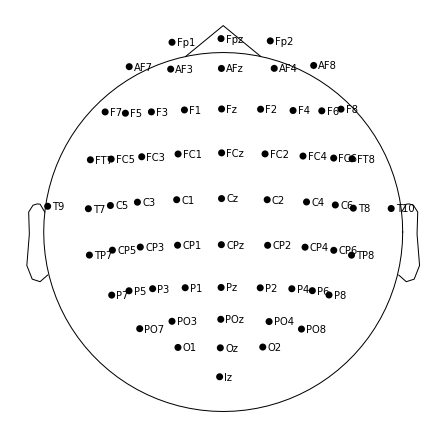

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


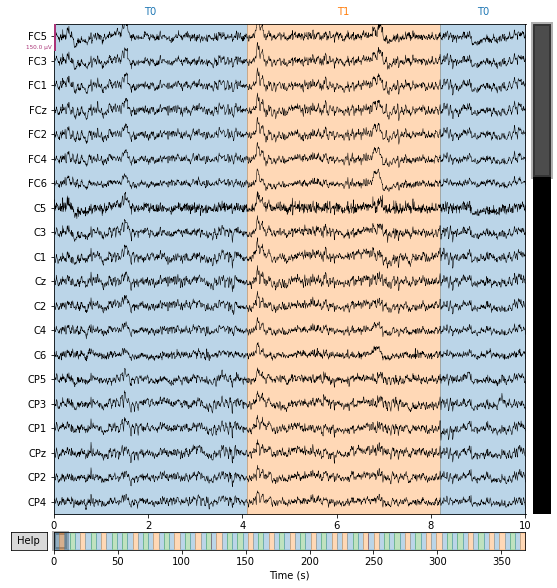


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>filter_data(raw, montage=make_standard_montage('standard_1020'))<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


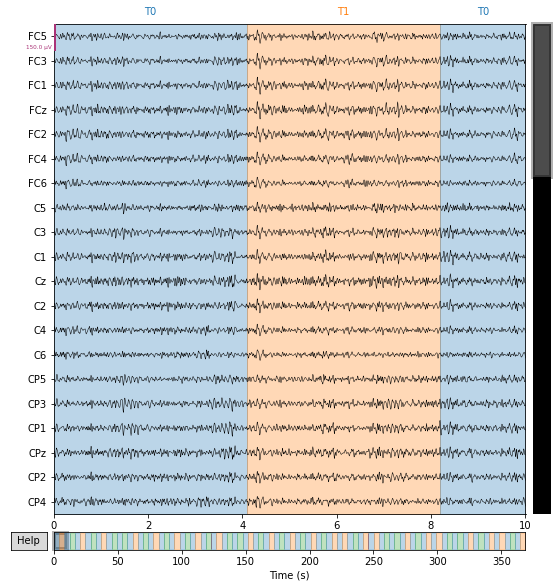


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>fetch_events(data_filtered, tmin=-1., tmax=4.)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
epochs_data.shape=(45, 64, 801)
epochs_data_train.shape=(45, 64, 161)
X=epochs_data_train, y=labels

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>csp.fit(X, y), X.shape=(45, 64, 161), y.shape=(45,)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

X.shape (45, 64, 161)
len(y) 45 [0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0
 1 1 0 1 0 0 1 0]
_classes [0 1]
_concat_cov: x_class.shape0=(23, 64, 161)
_concat_cov: x_

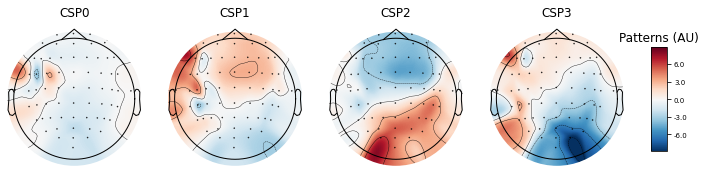

X=epochs_data, y=labels

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>csp.fit(X, y), X.shape=(45, 64, 801), y.shape=(45,)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

X.shape (45, 64, 801)
len(y) 45 [0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0
 1 1 0 1 0 0 1 0]
_classes [0 1]
_concat_cov: x_class.shape0=(23, 64, 801)
_concat_cov: x_class.shape1=(64, 23, 801)
_concat_cov: x_class.shape2=(64, 18423)
_concat_cov: x_class.shape3=(64, 18423), x_class.T.shape=(18423, 64), x_class.T.conj().shape=(18423, 64)
_concat_cov: cov.shape=(64, 64)
==_concat_cov==, n_channels=64, weight=64
compare cov, 1.1520202770084401e-10, cov1 1.1520196422112369e-10, True
_concat_cov: x_class.shape0=(22, 64, 801)
_concat_cov: x_class.shape1=(64, 22, 801)
_concat_cov: x_class.shape2=(64, 17622)
_concat_cov: x_class.shape3=(64, 17622), x_class.T.shape=(17622, 64), x_class.T.conj().shape=(17622, 64)
_co

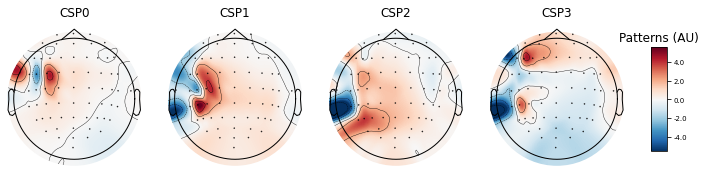


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>csp.fit(X, y), X.shape=(36, 64, 161), y.shape=(36,)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

X.shape (36, 64, 161)
len(y) 36 [1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1]
_classes [0 1]
_concat_cov: x_class.shape0=(18, 64, 161)
_concat_cov: x_class.shape1=(64, 18, 161)
_concat_cov: x_class.shape2=(64, 2898)
_concat_cov: x_class.shape3=(64, 2898), x_class.T.shape=(2898, 64), x_class.T.conj().shape=(2898, 64)
_concat_cov: cov.shape=(64, 64)
==_concat_cov==, n_channels=64, weight=64
compare cov, 1.0151984272885272e-10, cov1 1.0151728011962161e-10, True
_concat_cov: x_class.shape0=(18, 64, 161)
_concat_cov: x_class.shape1=(64, 18, 161)
_concat_cov: x_class.shape2=(64, 2898)
_concat_cov: x_class.shape3=(64, 2898), x_class.T.shape=(2898, 64), x_class.T.conj().shape=(2898, 64)
_concat_cov: cov.shape=(64, 64)
==_concat_cov==, n_cha

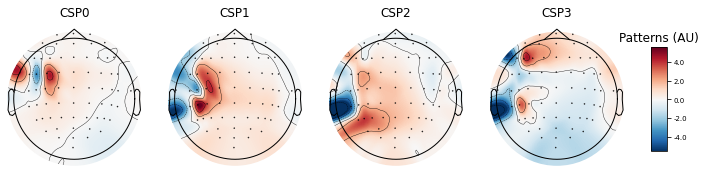


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>csp.fit(X, y), X.shape=(45, 64, 161), y.shape=(45,)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

X.shape (45, 64, 161)
len(y) 45 [0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0
 1 1 0 1 0 0 1 0]
_classes [0 1]
_concat_cov: x_class.shape0=(23, 64, 161)
_concat_cov: x_class.shape1=(64, 23, 161)
_concat_cov: x_class.shape2=(64, 3703)
_concat_cov: x_class.shape3=(64, 3703), x_class.T.shape=(3703, 64), x_class.T.conj().shape=(3703, 64)
_concat_cov: cov.shape=(64, 64)
==_concat_cov==, n_channels=64, weight=64
compare cov, 1.0145772452005826e-10, cov1 1.0145604580361454e-10, True
_concat_cov: x_class.shape0=(22, 64, 161)
_concat_cov: x_class.shape1=(64, 22, 161)
_concat_cov: x_class.shape2=(64, 3542)
_concat_cov: x_class.shape3=(64, 3542), x_class.T.shape=(3542, 64), x_class.T.conj().shape=(3542, 64)
_concat_cov: cov.shape=(64, 64)
==_

In [8]:

def training():

    raw = filter_data(raw=prepare_data(raw=fetch_data(raw_fnames=raw_filenames())))
    labels, epochs = fetch_events(raw)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)

    epochs_data = epochs.get_data()
    print(f'epochs_data.shape={epochs_data.shape}')
    epochs_data_train = epochs_train.get_data()
    print(f'epochs_data_train.shape={epochs_data_train.shape}')

    # Define a monte-carlo cross-validation generator (reduce variance):
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    #cv_split = cv.split(epochs_data_train)
    
    # Assemble a classifier
    lda_shrinkage = LDA(solver='lsqr', shrinkage='auto')
    csp = FT_CSP()
    #csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

    # csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
    print('X=epochs_data_train, y=labels')
    csp.fit_transform(epochs_data_train, labels)
    csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
    print('X=epochs_data, y=labels')
    csp.fit_transform(epochs_data, labels)
    csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

    #return

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LDA', lda_shrinkage)])
    scores_ldashrinkage = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    mean_scores_ldashrinkage, std_scores_ldashrinkage = np.mean(scores_ldashrinkage), np.std(scores_ldashrinkage)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print('-'*42)
    print("LDA SHRINKED Classification accuracy: %f / Chance level: %f" % (np.mean(scores_ldashrinkage), class_balance))
    print(f"Mean Score Model {mean_scores_ldashrinkage}")
    print(f"Std Score Model {std_scores_ldashrinkage}")
    print('-'*42)

    # plot CSP patterns estimated on full data for visualization
    csp.fit_transform(epochs_data, labels)
    csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

    # save pipeline
    clf = clf.fit(epochs_data_train, labels)
    dump(clf, "final_model.joblib")
    print("model saved to final_model.joblib")
    pass

training()


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>raw_filenames()<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<




>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>fetch_data(raw_fnames, sfreq=None, bPrint=True)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29

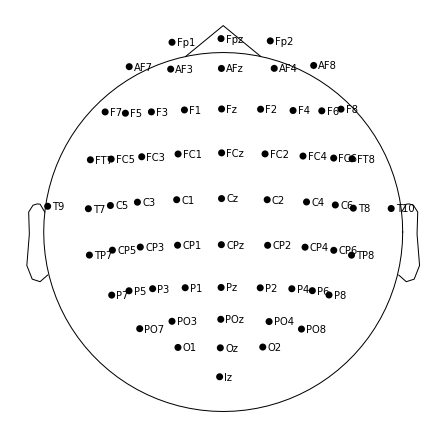

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


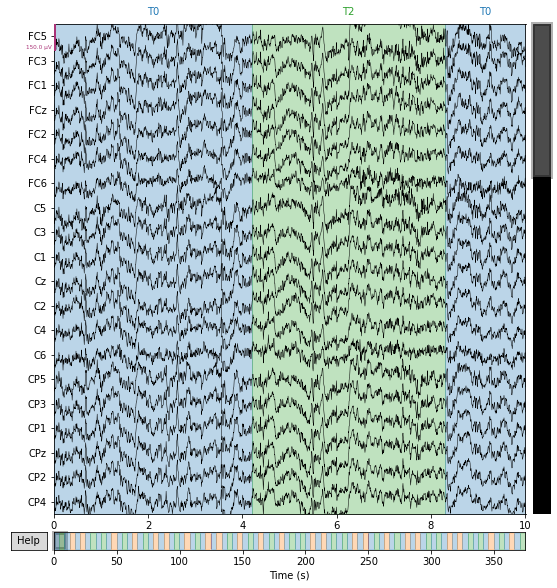


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>filter_data(raw, montage=make_standard_montage('standard_1020'))<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


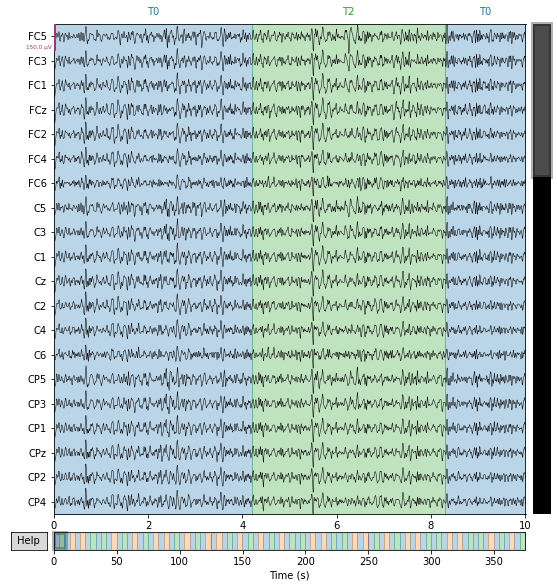


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>filter_data(raw, montage=make_standard_montage('standard_1020'))<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


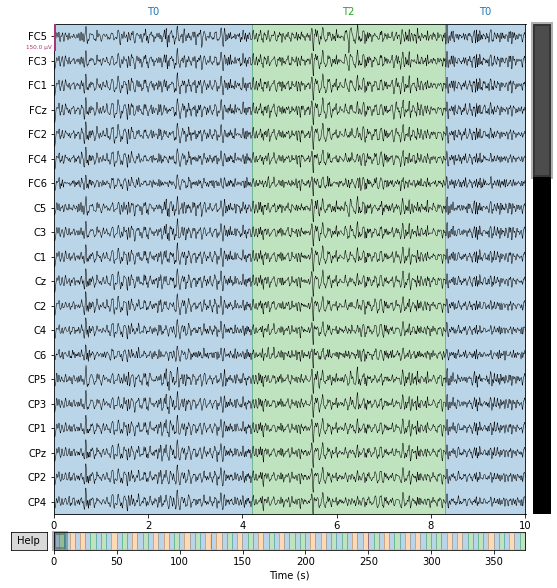


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>fetch_events(data_filtered, tmin=-1., tmax=4.)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
X shape=  (45, 64, 801) y shape=  (45,)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>csp.transform(X), X.shape=(1, 64, 801)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

pred=  [1] truth=  [1]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>csp.transform(X), X.shape=(1, 64, 801)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

pred=  [1] truth=  [0]

>>>>>>

In [9]:
PREDICT_MODEL = "final_model.joblib"
SUBJECTS = [1]

def predict():
    try:
        clf = load(PREDICT_MODEL)
    except FileNotFoundError as e:
        raise Exception(f"File not found: {PREDICT_MODEL}")

    # Fetch Data
    raw = filter_data(raw=prepare_data(raw=fetch_data(raw_fnames=raw_filenames())))
    labels, epochs = fetch_events(filter_data(raw))
    epochs = epochs.get_data()

    print("X shape= ", epochs.shape, "y shape= ", labels.shape)

    scores = []
    for n in range(epochs.shape[0]):
        pred = clf.predict(epochs[n:n + 1, :, :])
        print("pred= ", pred, "truth= ", labels[n:n + 1])
        scores.append(1 - np.abs(pred[0] - labels[n:n + 1][0]))
    print("Mean acc= ", np.mean(scores))

predict()


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>raw_filenames()<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>fetch_data(raw_fnames, sfreq=None, bPrint=True)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.

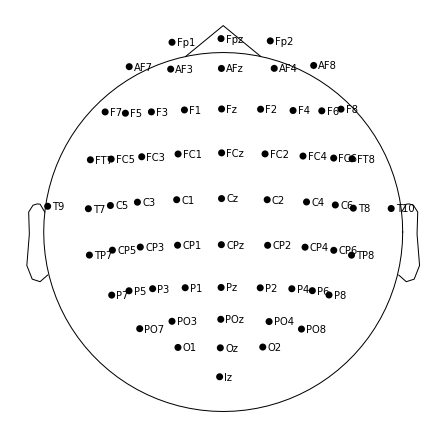

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


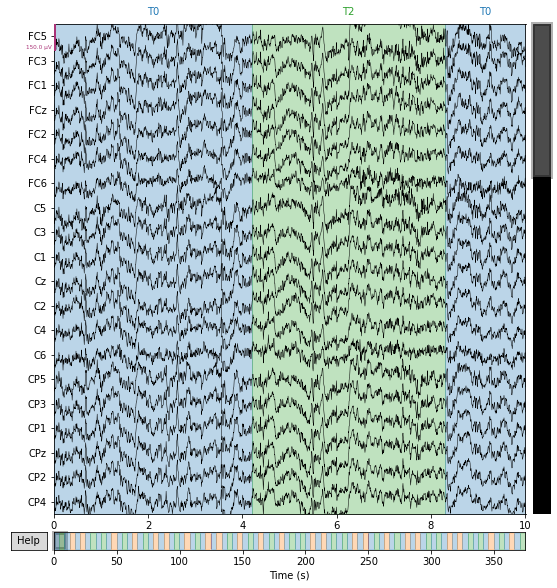


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>filter_data(raw, montage=make_standard_montage('standard_1020'))<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


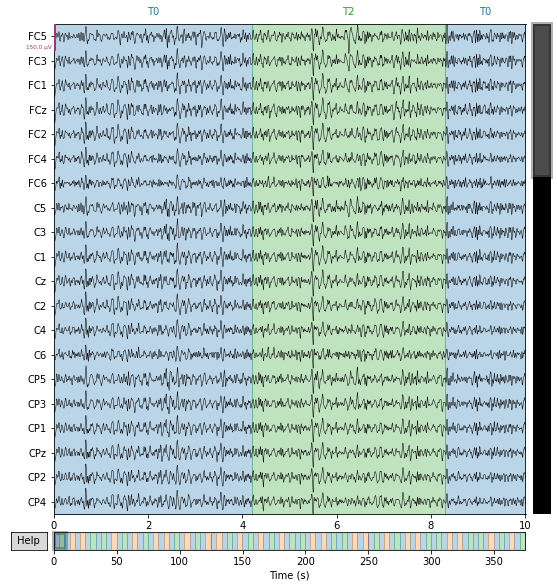


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>fetch_events(data_filtered, tmin=-1., tmax=4.)<<<
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 0.00023 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank

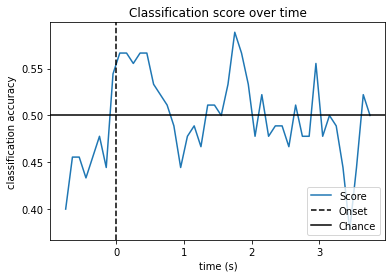

Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)


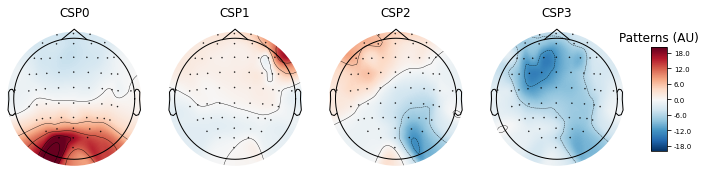

X shape=  (23, 64, 801) y shape=  (23,)
n= 0 pred=  [0] truth=  [1]
n= 1 pred=  [1] truth=  [1]
n= 2 pred=  [0] truth=  [0]
n= 3 pred=  [1] truth=  [0]
n= 4 pred=  [0] truth=  [1]
n= 5 pred=  [1] truth=  [1]
n= 6 pred=  [1] truth=  [0]
n= 7 pred=  [0] truth=  [0]
n= 8 pred=  [1] truth=  [1]
n= 9 pred=  [1] truth=  [0]
n= 10 pred=  [1] truth=  [1]
n= 11 pred=  [1] truth=  [0]
n= 12 pred=  [1] truth=  [0]
n= 13 pred=  [0] truth=  [1]
n= 14 pred=  [1] truth=  [1]
n= 15 pred=  [1] truth=  [0]
n= 16 pred=  [0] truth=  [0]
n= 17 pred=  [1] truth=  [1]
n= 18 pred=  [0] truth=  [1]
n= 19 pred=  [0] truth=  [0]
n= 20 pred=  [0] truth=  [1]
n= 21 pred=  [0] truth=  [0]
n= 22 pred=  [1] truth=  [1]
Mean acc=  0.5217391304347826


In [11]:
dataset = []
subject = []
sfreq = None


def pipeline():
    #raw = filter_data(raw=prepare_data(raw=fetch_data(raw_fnames=raw_filenames())))
    #labels, epochs = fetch_events(filter_data(raw))

    raw_fnames = raw_filenames()
    raw = fetch_data(raw_fnames)
    raw = prepare_data(raw)
    raw = filter_data(raw)
    labels, epochs = fetch_events(raw)

    epochs_data_train = epochs.get_data()
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)

    # Assemble a classifier
    lda = LDA()
    lda_shrinkage = LDA(solver='lsqr', shrinkage='auto')
    svc = SVC(gamma='auto')

    csp = CSP()

    #classifiers
    clf1 = Pipeline([('CSP', csp), ('LDA', lda)])
    scores_lda = cross_val_score(clf1, epochs_data_train, labels, cv=cv, n_jobs=1)
    mean_scores_lda, std_scores_lda = np.mean(scores_lda), np.std(scores_lda)
    
    clf2 = Pipeline([('CSP', csp), ('LDA', lda_shrinkage)])
    scores_ldashrinkage = cross_val_score(clf2, epochs_data_train, labels, cv=cv, n_jobs=1)
    mean_scores_ldashrinkage, std_scores_ldashrinkage = np.mean(scores_ldashrinkage), np.std(scores_ldashrinkage)
    
    clf3 = Pipeline([('CSP', csp), ('SVC', svc)])
    scores_svc = cross_val_score(clf3, epochs_data_train, labels, cv=cv, n_jobs=1)
    mean_scores_svc, std_scores_svc = np.mean(scores_svc), np.std(scores_svc)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)

    print('-'*42)
    print("LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda), class_balance))
    print(f"Mean Score Model {mean_scores_lda}")
    print(f"Std Score Model {std_scores_lda}")
    print('-'*42)
    print("LDA SHRINKED Classification accuracy: %f / Chance level: %f" % (np.mean(scores_ldashrinkage), class_balance))
    print(f"Mean Score Model {mean_scores_ldashrinkage}")
    print(f"Std Score Model {std_scores_ldashrinkage}")
    print('-'*42)
    print("SVC Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svc), class_balance))
    print(f"Mean Score Model {mean_scores_svc}")
    print(f"Std Score Model {std_scores_svc}")
    print('-'*24)

    ####################
    # https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#ex-decoding-csp-eeg
    # Look at performance over time
    ####################
    sfreq = raw.info['sfreq']
    w_length = int(sfreq * 0.5)   # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

    scores_windows = []

    for train_idx, test_idx in cv.split(epochs_data_train):
        y_train, y_test = labels[train_idx], labels[test_idx]

        X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
        X_test = csp.transform(epochs_data_train[test_idx])

        # fit classifier
        lda_shrinkage.fit(X_train, y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []
        for n in w_start:
            X_test = csp.transform(epochs_data_train[test_idx][:, :, n:(n + w_length)])
            score_this_window.append(lda_shrinkage.score(X_test, y_test))
        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

    plt.figure()
    plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
    plt.axvline(0, linestyle='--', color='k', label='Onset')
    plt.axhline(0.5, linestyle='-', color='k', label='Chance')
    plt.xlabel('time (s)')
    plt.ylabel('classification accuracy')
    plt.title('Classification score over time')
    plt.legend(loc='lower right')
    plt.show()
    ####################

    lda_shrinkage.fit(csp.fit_transform(epochs_data_train, labels), labels)
    try:
        os.remove('model.joblib')
    except OSError:
        pass
    dump(lda_shrinkage, 'model.joblib')


    # Prediction

    pivot = int(0.5 * len(epochs_data_train))

    clf = clf2
    clf = clf.fit(epochs_data_train[:pivot], labels[:pivot])
    try :
        p = clf.named_steps["CSP"].plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
    except AttributeError:
        print("Method not implemented")

    print("X shape= ", epochs_data_train[pivot:].shape, "y shape= ", labels[pivot:].shape)

    scores = []
    for n in range(epochs_data_train[pivot:].shape[0]):
        pred = clf.predict(epochs_data_train[pivot:][n:n + 1, :, :])
        print("n=", n, "pred= ", pred, "truth= ", labels[pivot:][n:n + 1])
        scores.append(1 - np.abs(pred[0] - labels[pivot:][n:n + 1][0]))
    print("Mean acc= ", np.mean(scores))
    pass


pipeline()


